# SG-MCMC Sampling - Hands-on
This notebook implements sgmcmc samplers to test them on simple landscapes. So we are able to get a feeling for their differences and behavior.

In [1]:
import jax.numpy as jnp
import os

from enhancing_sgmcmc.samplers.sghmc import SGHMC
from enhancing_sgmcmc.utils import (
    gaussian_mixture_logprob,
    generate_gmm_data,
    gmm_grad_estimator,
    run_sequential_sghmc,
    plot_gmm_sampling,
)

In [2]:
os.chdir("..")

In [3]:
%load_ext autoreload
%autoreload 2

### Setup

In [4]:
seed = 567

In [5]:
means = jnp.array([[1, 3]])
covs = jnp.array(
    [
        [[1, 0], [0, 1]],
    ]
)
weights = jnp.array([1])
data_samples = 1000

In [6]:
sampler = SGHMC(gmm_grad_estimator)
init_position = jnp.array([0.0, 0.0])

samples = generate_gmm_data(
    seed=seed, means=means, covs=covs, weights=weights, n_samples=data_samples
)

In [7]:
init_m = jnp.array([10, 0.1])
step_size = 0.05
mdecay = 0.05
burnin = 100
n_batches = 5
mcmc_samples = 1000

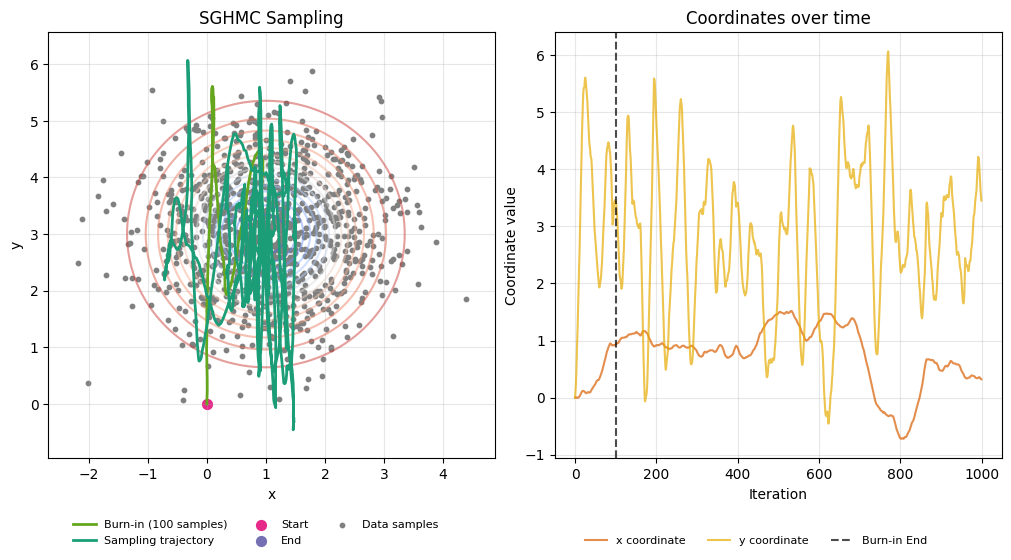

In [9]:
trajectory = run_sequential_sghmc(
    sampler=sampler,
    data=samples,
    init_position=init_position,
    init_m=init_m,
    batch_size=len(samples) // n_batches,
    n_samples=mcmc_samples,
    step_size=step_size,
    mdecay=mdecay,
    num_integration_steps=1,
    mresampling=0.01,
    seed=seed,
)

fig, ax = plot_gmm_sampling(
    trajectory=trajectory,
    samples=samples,
    means=means,
    covs=covs,
    weights=weights,
    gaussian_mixture_logprob=gaussian_mixture_logprob,
    title="SGHMC Sampling",
    burnin=burnin,
    figsize=(10, 5),
)

In [11]:
fig.savefig("gmm_sghmc.png", dpi=300, bbox_inches="tight")